Import All Packages

In [2]:
import pandas as pd
import numpy as np
import time

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
from matplotlib.pyplot import cm
%matplotlib inline

from sklearn.manifold import TSNE

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
# from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, f1_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


from sklearn.preprocessing import OneHotEncoder


Load All Data

In [3]:
def load_data(maxLines, duplicates):

    """
        Import datasets, select features and define the default-flag collumn.
    """
    
    col_acq = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
            'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
            'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
            'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd']
    
    extended_selec_acq = ['LoanID', 'OrLTV', 'LoanPurpose', 'DTIRat', 'PropertyType', 'FTHomeBuyer', 'Channel', 'SellerName','OrInterestRate', 'CreditScore', 'NumBorrow', 'OrDate'] 
    col_acq_subset = extended_selec_acq 
    
    col_per = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
              'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
              'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
              'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
              'FPWA','ServicingIndicator'] 
    
    extended_selec_per = ['LoanID', 'MonthsToMaturity', 'CurrInterestRate', 'ForeclosureDate', 'LoanAge', 'CLDS', 'MaturityDate','ZeroBalCode', 'MonthRep']
    
    col_per_subset =  extended_selec_per 
    
    lines_to_read = maxLines
    aquisition_frame = pd.read_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/Acquisition_2007Q4.txt', sep='|', names=col_acq, usecols=col_acq_subset, index_col=False, nrows=lines_to_read )
    performance_frame = pd.read_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/Performance_2007Q4.txt', sep='|', names=col_per, usecols=col_per_subset, index_col=False, nrows=lines_to_read) 

    """ Fix the IDs in the observation set by fixing their reporting date AND requiring that the files are healthy. """
    
    observation_frame = performance_frame[(performance_frame.MonthRep == '12/01/2017') & 
                                (   (performance_frame.CLDS == '0') | 
                                    (performance_frame.CLDS == '1') | 
                                    (performance_frame.CLDS == '2')
                                )
                                ]
    obs_ids = observation_frame.LoanID
    
    """ Load only the observation IDs in the performance frame initially. """
    pf = performance_frame[performance_frame.LoanID.isin(obs_ids)]
    
    """ Keep only the reporting dates that are in our performance period (MM/DD/YYYY format). """
    pf_obs = pf[
                    (pf.MonthRep == '01/01/2018') | 
                    (pf.MonthRep == '02/01/2018') |
                    (pf.MonthRep == '03/01/2018') |
                    (pf.MonthRep == '04/01/2018') |
                    (pf.MonthRep == '05/01/2018') |
                    (pf.MonthRep == '06/01/2018') |
                    (pf.MonthRep == '07/01/2018') |
                    (pf.MonthRep == '08/01/2018') |
                    (pf.MonthRep == '09/01/2018') |
                    (pf.MonthRep == '10/01/2018') |
                    (pf.MonthRep == '11/01/2018') |
                    (pf.MonthRep == '12/01/2018') 
                ]
    
    """ 
    Find the LoanIDs of those loans where a default appears in our performance period.
    """
    pf_obs_defaults = pf_obs[
                            (pf_obs.CLDS != '0') &
                            (pf_obs.CLDS != '1') &
                            (pf_obs.CLDS != '2') &
                            (pf_obs.CLDS != 'X')
                        ].LoanID
    
    pf_obs_defaults.drop_duplicates(keep='last', inplace=True)
    
    """ Merge the acquisition and performance frames. """
    df = pd.merge(aquisition_frame, observation_frame, on = 'LoanID', how='inner')
    
    df['Default'] = 0
    df.loc[df['LoanID'].isin(pf_obs_defaults), 'Default'] = 1
    
    
    return df

In [4]:
def label_encode(df):
    df = df.apply(LabelEncoder().fit_transform)
    return df

In [5]:
def one_hot_encode(df):
    enc = OneHotEncoder(handle_unknown='ignore')
    df = enc.transform(df)
    return df

In [6]:
def get_na_columns(df):
    na_columns = df.columns[df.isnull().any()]
    return na_columns

In [7]:
def get_cat_feat(df):
    cat_feat = df.select_dtypes(include=['object']).columns
    return cat_feat

def get_num_feat(df):
    num_feat = df.select_dtypes(exclude=['object']).columns
    return num_feat

In [8]:
def normalize(df):
    df_norm = df
    df_norm = df_norm.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return df_norm

In [9]:
def makeDateNumeric(text):
    numMonths = int(text[:2])
    numYears = int(text[3:7])
    result = (numYears - 2000) * 12 + numMonths
    return result


def makeDayNumeric(text):
    numMonths = int(text[:2])
    numYears = int(text[6:10])
    result = (numYears - 2000) * 12 + numMonths
    return result

def make_dates_numeric(df):
    # TRANSFORM DATES TO NUMBER OF MONTHS (STARTING FROM 01/2000)
    df['MonthRep'] = df['MonthRep'].apply(makeDayNumeric)
    df['OrDate'] = df['OrDate'].apply(makeDateNumeric)
    df['FirstPayment'] = df['FirstPayment'].apply(makeDateNumeric)
    df['MaturityDate'] = df['MaturityDate'].apply(makeDateNumeric)

In [10]:
def to_2D(df):
        # TSNE - Dimentionality reduction
    print ('Training T-SNE ...')

    tsne = TSNE(n_components=2, random_state=1, n_iter=250, verbose=1)
    df_2D = tsne.fit_transform(df)
    df_2D = pd.DataFrame(df_2D)
    return df_2D

In [11]:
def tsne_visual(df):   
        # TSNE - Dimentionality reduction
    print ('Training T-SNE ...')

    tsne = TSNE(n_components=2, random_state=1, n_iter=250, verbose=1)
    df_2D = tsne.fit_transform(df.drop('Default', axis=1))
    df_2D = pd.DataFrame(df_2D)
    
    
    #Making plot
    plt.figure(figsize=(20,10))
    color = cm.rainbow(np.linspace(0,1, max(map(abs, set(df['Default'])))+1))
    for i in range(0, len(df_2D)):
        c1 = plt.scatter(df_2D.iloc[i][0], 
                         df_2D.iloc[i][1],
                     c = color[int(df.iloc[i]['Default'])],
                     marker=r"$ {} $".format(int(df.iloc[i]['Default'])), s=150, edgecolors='none')

    plt.xlabel('T-SNE Dim 1')
    plt.ylabel('T-SNE Dim 2')
    plt.title('Actives')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('Actives' + '.pdf', format='pdf', dpi=900)
    plt.show()

MAIN

Index(['Channel', 'SellerName', 'OrDate', 'FTHomeBuyer', 'LoanPurpose',
       'PropertyType', 'MonthRep', 'MaturityDate'],
      dtype='object')
Index(['OrInterestRate', 'OrLTV', 'NumBorrow', 'DTIRat', 'CreditScore',
       'CurrInterestRate', 'LoanAge', 'MonthsToMaturity', 'Default', 'Channel',
       'SellerName', 'OrDate', 'FTHomeBuyer', 'LoanPurpose', 'PropertyType',
       'MonthRep', 'MaturityDate'],
      dtype='object')
Training T-SNE ...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 160 samples in 0.000s...
[t-SNE] Computed neighbors for 160 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 160 / 160
[t-SNE] Mean sigma: 4.810965
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.427433
[t-SNE] Error after 251 iterations: 1797693134862315708145274237317043567980705675258449965989174768031572607800285387605895586327668781715404589535143824642343213268894641827684675467035375169860499105765512820762454900903893289440758685

No handles with labels found to put in legend.


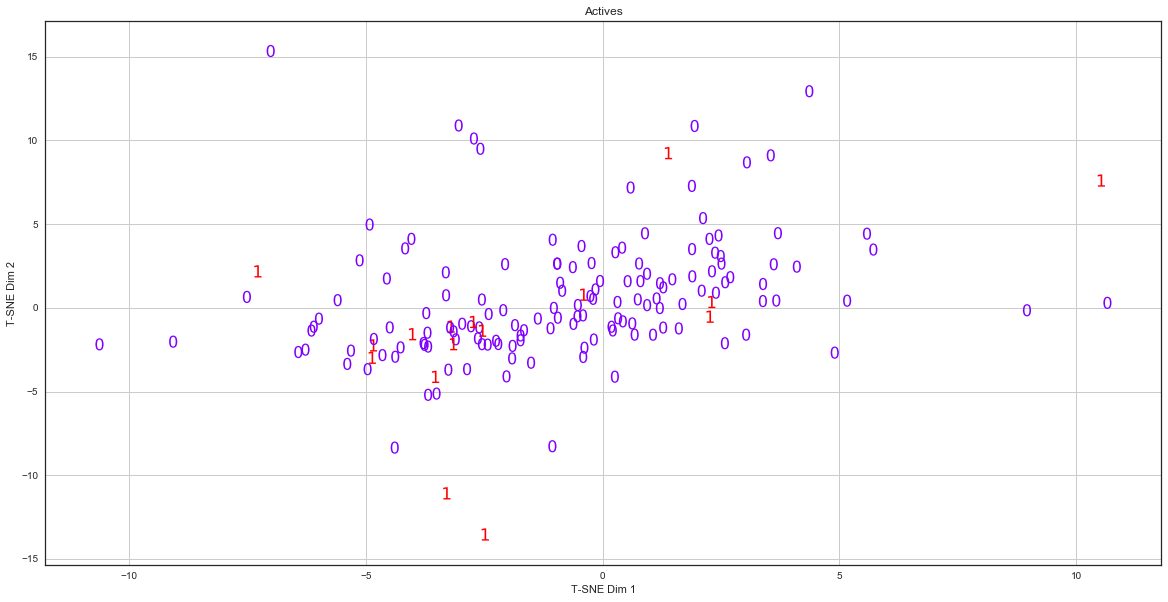

In [21]:
df = load_data(100000, False)
# make_dates_numeric(df)

# FORCE FEATURES TO BE INCLUDED
df = df[pd.notnull(df['CreditScore'])]
df = df[pd.notnull(df['DTIRat'])]

# FORCE FEATURES TO BE EXCLUDED
df = df.drop('LoanID',axis=1)
df = df.drop('CLDS',axis=1)

# FORCE FEATURE TO BE CATEGORICAL
# df['Zip'] = df['Zip'].astype('object',copy=False)
# df['MSA'] = df['MSA'].astype('object',copy=False)


na_columns = get_na_columns(df)
df = df.drop(na_columns,axis=1)

cat_feat = get_cat_feat(df)
cat_data = df[cat_feat]
print(cat_feat)
cat_data = label_encode(cat_data)

num_feat = get_num_feat(df)
num_data = normalize(df[num_feat])


df = pd.concat([num_data, cat_data], axis=1)
print(df.columns)


tsne_visual(df)

MAIN 2

In [13]:
df.head()

,OrInterestRate,OrLTV,NumBorrow,DTIRat,CreditScore,CurrInterestRate,LoanAge,MonthsToMaturity,Default,Channel,SellerName,OrDate,FTHomeBuyer,LoanPurpose,PropertyType,MonthRep,MaturityDate
0,0.565217,0.597403,0.0,0.807018,0.267101,0.510638,0.090909,0.438679,1.0,0,9,7,0,2,3,0,64
1,0.565217,0.116883,0.0,0.824561,0.286645,0.382979,0.181818,0.891509,0.0,0,1,6,0,0,3,0,67
2,0.521739,1.000000,0.5,0.526316,0.566775,0.765957,0.181818,0.436321,0.0,1,1,6,0,2,3,0,57
3,0.521739,0.415584,0.0,0.631579,0.276873,0.425532,0.000000,0.922170,0.0,0,4,8,0,0,3,0,6
4,0.521739,0.714286,0.0,0.210526,0.390879,0.765957,0.545455,0.426887,0.0,1,4,2,0,0,3,0,32


In [14]:
"""
    Split the target variable from the input variables.
""" 
y = df['Default']
X = df.drop(['Default'], axis=1)

In [16]:
print(y.value_counts())
df.head()

0.0    144
1.0     16
Name: Default, dtype: int64


,OrInterestRate,OrLTV,NumBorrow,DTIRat,CreditScore,CurrInterestRate,LoanAge,MonthsToMaturity,Default,Channel,SellerName,OrDate,FTHomeBuyer,LoanPurpose,PropertyType,MonthRep,MaturityDate
0,0.565217,0.597403,0.0,0.807018,0.267101,0.510638,0.090909,0.438679,1.0,0,9,7,0,2,3,0,64
1,0.565217,0.116883,0.0,0.824561,0.286645,0.382979,0.181818,0.891509,0.0,0,1,6,0,0,3,0,67
2,0.521739,1.000000,0.5,0.526316,0.566775,0.765957,0.181818,0.436321,0.0,1,1,6,0,2,3,0,57
3,0.521739,0.415584,0.0,0.631579,0.276873,0.425532,0.000000,0.922170,0.0,0,4,8,0,0,3,0,6
4,0.521739,0.714286,0.0,0.210526,0.390879,0.765957,0.545455,0.426887,0.0,1,4,2,0,0,3,0,32


In [17]:
from imblearn.over_sampling import RandomOverSampler

In [18]:
sm = RandomOverSampler()

n_1 = sum(y)
n_0 = len(y) - sum(y)

# sm = SMOTE()

X_cols = X.columns
X, y = sm.fit_sample(X, y) # fit_sample takes a dataframe, but returns an array. 
(X, y) = (pd.DataFrame(X, columns=X_cols), pd.Series(y))
print(y.value_counts())

0.0    144
1.0    144
dtype: int64


In [19]:
# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
# y = np.array([0, 0, 1, 1])
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

print(skf)

from xgboost import XGBClassifier
model = XGBClassifier()

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [20]:
for train_index, test_index in skf.split(X, y):
    
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(y_train.isnull().values.any())
    
    # fit model on training data
    model.fit(X_train, y_train)
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    # evaluate predictions
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0), "|| AUC: %.2f%%" % (auc * 100.0), "|| F1 - Score: %.2f%%" % (f1 * 100.0))

False
Accuracy: 93.33% || AUC: 93.33% || F1 - Score: 93.75%
False
Accuracy: 90.00% || AUC: 90.00% || F1 - Score: 90.91%
False
Accuracy: 96.67% || AUC: 96.67% || F1 - Score: 96.77%
False
Accuracy: 93.33% || AUC: 93.33% || F1 - Score: 93.75%
False
Accuracy: 100.00% || AUC: 100.00% || F1 - Score: 100.00%
False
Accuracy: 96.43% || AUC: 96.43% || F1 - Score: 96.55%
False
Accuracy: 100.00% || AUC: 100.00% || F1 - Score: 100.00%
False
Accuracy: 92.86% || AUC: 92.86% || F1 - Score: 93.33%
False
Accuracy: 96.43% || AUC: 96.43% || F1 - Score: 96.55%
False
Accuracy: 100.00% || AUC: 100.00% || F1 - Score: 100.00%


In [35]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
thresholds

array([0.9810524 , 0.9646315 , 0.940282  , 0.93064356, 0.8995881 ,
       0.00575597], dtype=float32)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        14
        1.0       1.00      1.00      1.00        14

avg / total       1.00      1.00      1.00        28



Text(1,1,'Sampling algorithm: RandomOverSampling')

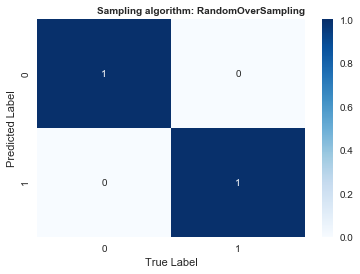

In [42]:
"""
    Output statistics - confusion matrix
"""

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred).T
cm = cm.astype('float')/cm.sum(axis=0)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.set_title('Sampling algorithm: ' + "RandomOverSampling", loc='right', fontsize=10, fontweight='bold')